In [2]:
!pip install pytorch_metric_learning
!pip install online_triplet_loss

In [3]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from online_triplet_loss.losses import *

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
from fastbook import *


import ds_omniglot
import ds_sigcomp2009
import ds_mnist
import ds_cedar

from dataset_siamese import *
from dl_models import *
from tools import *
from embeddings import *

/home/marian/anaconda3/envs/ml/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Paths

In [6]:
path_omniglot = Path('./data/omniglot')

path_sigcomp = Path('./data/sigcomp2009')

path_cedar = Path('./data/cedar')

path_mnist = untar_data(URLs.MNIST)

# Datasets

In [7]:
train_ds, valid_ds = calc_dss(path_omniglot, 
                              get_image_files, 
                              ds_omniglot.get_x, 
                              ds_omniglot.get_y, 
                              ds_omniglot.is_validation)

32460 files loaded.
19280 training samples / 13180 validation samples


In [8]:
train_ds, valid_ds = calc_dss(path_sigcomp,
                              ds_sigcomp2009.get_authentic_signatures,
                              ds_sigcomp2009.get_x, 
                              ds_sigcomp2009.get_y, 
                              ds_sigcomp2009.is_test)

1000 files loaded.
60 training samples / 940 validation samples


In [9]:
train_ds, valid_ds = calc_dss(path_cedar, 
                              get_image_files,
                              ds_cedar.get_x, 
                              ds_cedar.get_y, 
                              ds_cedar.is_validation)

1320 files loaded.
1056 training samples / 264 validation samples


In [10]:
train_ds, valid_ds = calc_dss(path_mnist, 
                              get_image_files,
                              ds_mnist.get_x, 
                              ds_mnist.get_y, 
                              ds_mnist.is_validation)

70000 files loaded.
55165 training samples / 14835 validation samples


# Stats

In [11]:
fns_omniglot_train = get_image_files(path_omniglot/'images_background')
fns_omniglot_test  = get_image_files(path_omniglot/'images_evaluation')

omniglot_stats = get_stats(fns_omniglot_train, ds_omniglot.get_x, n_sample='all')
omniglot_stats

KeyboardInterrupt: 

In [ ]:
fns_cedar_train = list(filter(ds_cedar.is_validation,get_image_files(path_cedar)))

cedar_stats = get_stats(fns_cedar_train, ds_cedar.get_x, n_sample='all')
cedar_stats

In [ ]:
fns_mnist = get_image_files_truncated(10000)(path_mnist)

mnist_stats = get_stats(fns_mnist, get_x_mnist, n_sample='all')
mnist_stats

In [ ]:
fns_sigcomp_train  = get_originals_train(path_sigcomp_train)

sigcomp_train_stats = get_stats(fns_sigcomp_train, get_x_sigcomp2009, n_sample='all')
sigcomp_train_stats

In [ ]:
stats = 0.0780, 0.2681 # omniglot

In [ ]:
stats = 36.8690, 89.6788 # mnist

In [ ]:
stats = 0.0594, 0.2364 # sigcomp2009

# DataLoaders

In [8]:
bs = 32

In [6]:
bs = 128

In [9]:
stats = imagenet_stats

In [55]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, 
    after_item=[Resize(224, ResizeMethod.Squish), ToTensor],  
    after_batch=[IntToFloatTensor, Normalize(),
                 *aug_transforms(do_flip=False)])

In [56]:
dls=dls.cuda()

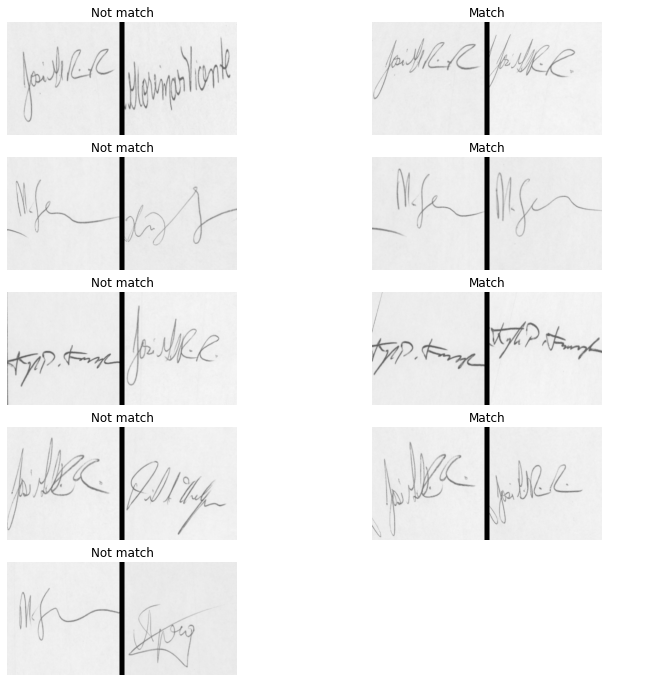

In [57]:
dls.valid.show_batch()

In [58]:
b=dls.valid.one_batch()
len(b), b[0].shape, b[1].shape,  b[2].shape,

(3,
 torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]),
 torch.Size([32]))

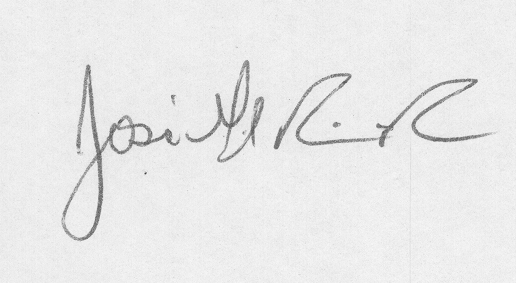

In [59]:
valid_ds[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

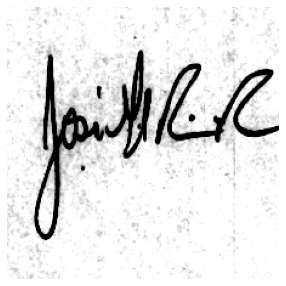

In [63]:
show_image(b[0][0]+1)

In [61]:
b[0][0]

TensorImage([[[ 0.1350,  0.0291, -0.0258,  ..., -0.0428,  0.0140,  0.1216],
         [ 0.1038,  0.1474,  0.1948,  ...,  0.0125,  0.0073,  0.0663],
         [ 0.1013,  0.1566,  0.2119,  ...,  0.1649,  0.1249,  0.1130],
         ...,
         [ 0.0323,  0.0330,  0.0337,  ...,  0.0637,  0.0300,  0.0325],
         [ 0.0840,  0.0305, -0.0016,  ...,  0.0109, -0.0017,  0.0273],
         [ 0.0870,  0.0535,  0.0535,  ...,  0.0816,  0.0395,  0.0314]],

        [[ 0.1350,  0.0291, -0.0258,  ..., -0.0428,  0.0140,  0.1216],
         [ 0.1038,  0.1474,  0.1948,  ...,  0.0125,  0.0073,  0.0663],
         [ 0.1013,  0.1566,  0.2119,  ...,  0.1649,  0.1249,  0.1130],
         ...,
         [ 0.0323,  0.0330,  0.0337,  ...,  0.0637,  0.0300,  0.0325],
         [ 0.0840,  0.0305, -0.0016,  ...,  0.0109, -0.0017,  0.0273],
         [ 0.0870,  0.0535,  0.0535,  ...,  0.0816,  0.0395,  0.0314]],

        [[ 0.1350,  0.0291, -0.0258,  ..., -0.0428,  0.0140,  0.1216],
         [ 0.1038,  0.1474,  0.1948,  ..

# Model

In [11]:
loss = nn.BCEWithLogitsLoss()
metric = accuracy_multi
m = SiameseModelNN(resnet18)

In [ ]:
loss = functools.partial(my_loss_func_LeCun, margin=margin)
metric = accuracy_dist
m = SiameseModelWithDistance(resnet18, nn.PairwiseDistance(p=2)).cuda()

In [12]:
m = m.cuda()

In [12]:
m = m.cpu()

In [13]:
test_model(m, dls)

t1.shape = torch.Size([128, 3, 224, 224]) t2.shape = torch.Size([128, 3, 224, 224])
encoder(t1).shape = torch.Size([128, 512, 7, 7]) encoder(t2).shape = torch.Size([128, 512, 7, 7])
target.shape = torch.Size([128])
out.shape = torch.Size([128])


/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
class CalcEmbs(Module):
    def __init__(self, arch):
        self.cnn = create_body(arch, n_in=3)
        self.embs = nn.Sequential(Flatten(),
                                  *LinBnDrop(25088, 128, bn=True, p=0.5, act=nn.ReLU(inplace=True)))
    def forward(self, x):
        return self.embs(self.cnn(x)) 


In [6]:
class CalcEmbs(Module):
    def __init__(self, arch):
        self.cnn = create_body(arch, n_in=3)
        self.embs = nn.Sequential(AdaptiveConcatPool2d(), Flatten())
    def forward(self, x):
        return self.embs(self.cnn(x)) 


In [58]:

import torch.optim as optim

kevin_distance = distances.LpDistance(p=2)
kevin_reducer = reducers.ThresholdReducer(low=0)
kevin_loss= losses.TripletMarginLoss(margin=2, distance=kevin_distance, reducer=kevin_reducer)
kevin_mining_func = miners.TripletMarginMiner(
    margin=2, distance=kevin_distance, type_of_triplets="semihard"
)
def loss(preds, labels):
    indices_tuple = kevin_mining_func(preds, labels)
    return kevin_loss(preds, labels, indices_tuple)

m = CalcEmbs(resnet34).cuda()

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )
optimizer = optim.Adam(m.parameters(), lr=0.01)
num_epochs = 10

device = torch.device("cuda")


for epoch in range(1, num_epochs + 1):
    train(m, kevin_loss, kevin_mining_func, device, dls.train, optimizer, epoch)
    testloss(m,kevin_loss, kevin_mining_func, device, dls.valid)
    #test(dataset1, dataset2, model, accuracy_calculator)


Epoch 1 Iteration 0: Loss = 1.9244749546051025, Number of mined triplets = 25371
2.328079660733541
Epoch 2 Iteration 0: Loss = 1.360321283340454, Number of mined triplets = 25957
2.3065876960754395
Epoch 3 Iteration 0: Loss = 1.3665016889572144, Number of mined triplets = 27626
2.322701613108317
Epoch 4 Iteration 0: Loss = 1.2637196779251099, Number of mined triplets = 31548
2.3039357662200928
Epoch 5 Iteration 0: Loss = 1.231373906135559, Number of mined triplets = 29489
2.316162347793579
Epoch 6 Iteration 0: Loss = 1.2074012756347656, Number of mined triplets = 28045
2.169202764829
Epoch 7 Iteration 0: Loss = 1.2066234350204468, Number of mined triplets = 27085
1.3938130338986714
Epoch 8 Iteration 0: Loss = 1.1251380443572998, Number of mined triplets = 31632
1.475096066792806
Epoch 9 Iteration 0: Loss = 1.0706619024276733, Number of mined triplets = 27508
2.062731226285299
Epoch 10 Iteration 0: Loss = 1.0363025665283203, Number of mined triplets = 32749
1.9871634244918823


In [ ]:
for epoch in range(1, 50):
    train(m, kevin_loss, kevin_mining_func, device, dls.train, optimizer, epoch)

Epoch 1 Iteration 0: Loss = 1.133514404296875, Number of mined triplets = 28993
Epoch 2 Iteration 0: Loss = 1.1639267206192017, Number of mined triplets = 31342


In [ ]:
m.eval()
dlls=dlls.cuda()
for batch_idx, (x0,x1, labels) in enumerate(dlls.valid):
    preds = kevin_distance(m(x0),m(x1)).diagonal() > 2
    print( (preds==labels).float().mean() )
    break

In [43]:
CosineSimilarity

NameError: name 'CosineSimilarity' is not defined

In [30]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def testloss(model, loss_func, mining_func, device, train_loader):
    model.eval()
    c = 0
    s = 1
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        c+=1
        s+=loss.item()
    print(s/c)



0.6195089221000671


In [ ]:
CategoryBlock(vocab = cls)

In [5]:
stats = imagenet_stats
fns = get_image_files(path_cedar)
vocab = { y:i for i,y in enumerate(set(map(ds_cedar.get_y,fns))) }

db = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock(vocab)),
                  get_items = get_image_files,
                  splitter = FuncSplitter(ds_cedar.is_validation),
                  get_y = ds_cedar.get_y,
                  get_x = ds_cedar.get_x,
                  item_tfms=Resize(460),
                  batch_tfms=[Normalize.from_stats(*stats), *aug_transforms(size=224, min_scale=0.75)])
dls = db.dataloaders(path_cedar,bs=128)
d

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/torch_core.py:317: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  with torch._C.DisableTorchFunction(): ret = _convert(func(*args, **(kwargs or {})), self.__class__)


In [7]:
m = CalcEmbs(resnet34)

In [8]:
m = m.cuda()
dls = dls.cuda()

In [9]:
l = Learner(dls, m, loss_func =  lambda x,y : batch_hard_triplet_loss(y, x, margin=1))

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=9.12010818865383e-07)

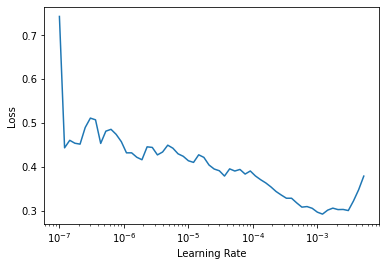

In [13]:
l.lr_find()

In [14]:
l.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,time
0,0.457184,3.389439,00:08
1,0.387286,3.173231,00:08
2,0.305516,3.109254,00:08
3,0.252203,3.031177,00:08
4,0.239251,2.903818,00:08
5,0.200406,2.801159,00:08
6,0.176828,2.762212,00:08
7,0.147637,2.732273,00:08
8,0.131553,2.760060,00:08
9,0.111778,2.759406,00:08


In [21]:
with torch.no_grad():
    m.eval()
    dlls=dlls.cuda()
    for batch_idx, (x0,x1, labels) in enumerate(dlls.valid):
        preds = nn.PairwiseDistance(p=2)(m(x0),m(x1))
        print(preds>1)
        break
        print( (preds==labels).float().mean() )
        break

TensorImage([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True], device='cuda:0')


In [38]:
b=dls.one_batch()
len(b), b[0].shape, b[1].shape

(2, torch.Size([64, 3, 224, 224]), torch.Size([64]))

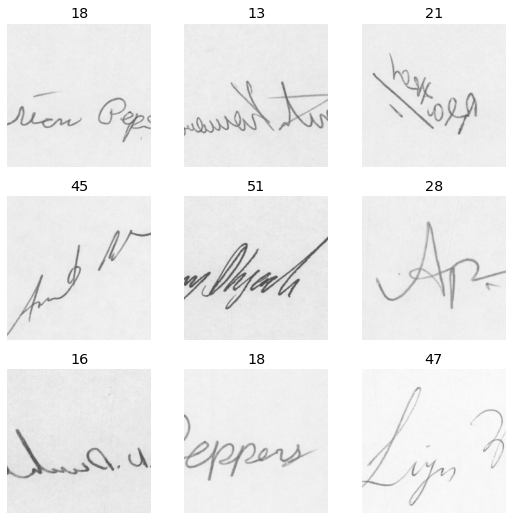

In [34]:
dls.show_batch()

In [11]:
l = Learner(dls, m, loss_func = loss)

In [55]:
l.validate()

(#1) [0.08974725753068924]

# Learner

In [12]:
l = Learner(dls, m, loss_func = loss, metrics = metric, splitter = type(m).splitter)

# Train Learner

In [14]:
l.freeze()

NameError: name 'l' is not defined

In [ ]:
l.unfreeze()

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.3182567499825382e-06)

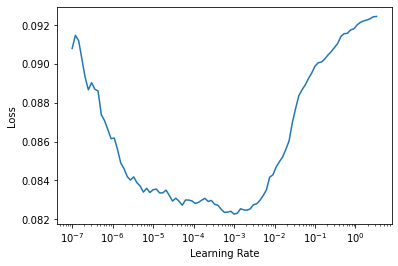

In [14]:
l.lr_find()

In [15]:
l.fit_one_cycle(10,1e-5)

epoch,train_loss,valid_loss,time
0,0.085229,0.087821,00:05
1,0.084437,0.089122,00:05
2,0.084241,0.087533,00:05
3,0.083917,0.088926,00:05
4,0.084137,0.088507,00:05
5,0.083625,0.088329,00:05
6,0.083229,0.087939,00:05
7,0.082949,0.087552,00:05
8,0.083600,0.087294,00:05
9,0.083506,0.087966,00:05


In [11]:
preds,targs = l.get_preds()

/home/jupyter/siamess/models.py:87: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  xs = torch.linspace(x0,xf)


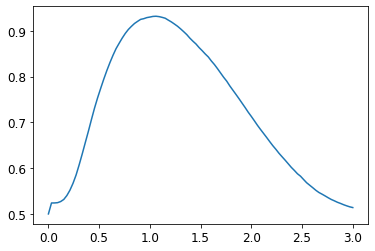

In [12]:
thresh_finder(preds, targs, accuracy_dist, 0,3)

In [16]:
accuracy_dist(preds, targs, thresh=1)

TensorImageBW(0.9149)

In [17]:
torch.save(l.model,"omniglot_distance.pt")

# Evaluate learner

In [47]:
learn.loss_func = my_loss_func_LeCun

In [ ]:
class Interprete2:
    def __init__(self, learn):
        self.learn = learn
        if isinstance(learn.model, SiameseModelWithDistance):
            self.model_type = 'dist'
        elif isinstance(learn.model, SiameseModelNN):
            self.model_type = 'mm'
        else:
            assert(False)

    def set_dl(self, dl, ds, d_thresh = 1):
        self.ds, self.ds = dl, ds
        self.act, self.y, self.loss = self.learn.get_preds(dl=dl, with_loss=True)
        if self.model_type == 'nn':
            self.pred = self.act.sigmoid() < 0.5
        else:
            self.pred = self.act < d_thresh
        self.ids = torch.argsort(self.loss, descending=True)

        # Accuracy
        self.acc = (self.pred==self.y).float().mean().item()
        # Error rate
        self.err = (self.pred!=self.y).float().mean().item()
        # Falsos rechazos
        self.frr = (self.y.bool() & (self.pred!=self.y)).float().mean().item()
        # Falsas aceptaciones
        self.far = (~self.y.bool() & (self.pred!=self.y)).float().mean().item()
        
    def stats(self):
        print(f'Accuracy: {self.acc}')
        print(f'Error rate: {self.err}')
        print(f'False Aceptation Ratio: {self.frr}')
        print(f'False Rejection Ratio: {self.far}')

interp = Interprete2(l)
interp.set_dl(dls.valid, valid_ds)

In [ ]:
interp.ds[0][0]

In [ ]:
interp.ds[0][1]

In [ ]:
interp.ds[0][2]

In [ ]:
interp.pred[0]

In [ ]:
interp.y

In [ ]:
interp.loss[0]

In [ ]:
for b in dls.valid:
    break
b

In [ ]:
show_image(b[0][0])

In [ ]:
interp.pred!=interp.y

In [ ]:
class SiameseImage(fastuple):
    def show(self, ctx=None, more_info="", **kwargs):
        if len(self) > 2:
            img1,img2,similarity = self
            match_msg = ['Not match','Match'][int(similarity)]
        else:
            img1,img2 = self
            similmatch_msgarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            if t1.ndim!=3: t1 = t1.unsqueeze(2)
            if t2.ndim!=3: t2 = t2.unsqueeze(2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=match_msg + " " + more_info, ctx=ctx, **kwargs)

def top_loss(tlids, pred, y, loss, ds, fn_info=False, kind='all', limit = 50):
    """ kind in {'all', 'frr', 'far'} """
    c = 0
    for i in tlids:
        if kind=='all' or (kind=='far' and ~y[i].bool()) or (kind=='frr' and y[i].bool()):
            fn_info_str = f'{ds.fns[i//2]} {ds.fns[ds.draw_memo[i]]}' if fn_info  else ''
            SiameseImage(ds[i][0], ds[i][1], ds[i][2]).show(more_info = f'pred:{pred[i]} loss:{loss[i]:.4f}' + fn_info_str)
            c+=1
            if c>=limit: break

top_loss(interp.ids, interp.pred, interp.y, interp.loss, interp.ds, fn_info=True, kind='frr',limit=10)

In [71]:
interp = Interprete(learn)
interp.set_dl(dls.valid, ds_valid)

In [72]:
interp.stats()

Accuracy: 0.9288315773010254
Error rate: 0.0711684376001358
False Aceptation Ratio: 0.04465098679065704
False Rejection Ratio: 0.02651745080947876


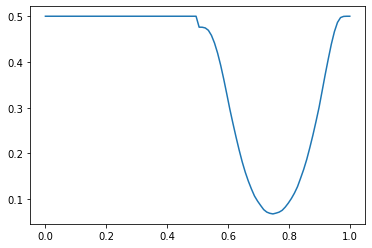

In [53]:
# Para NN Siamess
thresh_finder(interp.act, interp.y, accuracy_multi, 0, 1)

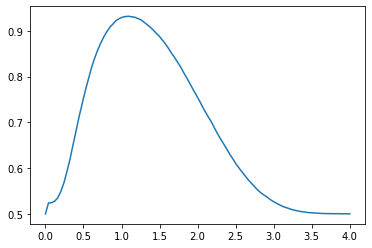

In [73]:
# Para Dist Siamess
thresh_finder(interp.act, interp.y, accuracy_dist, 0, 4)

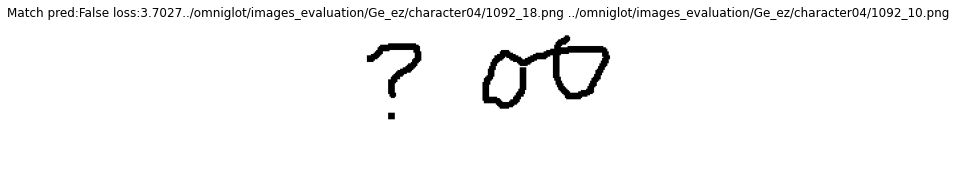

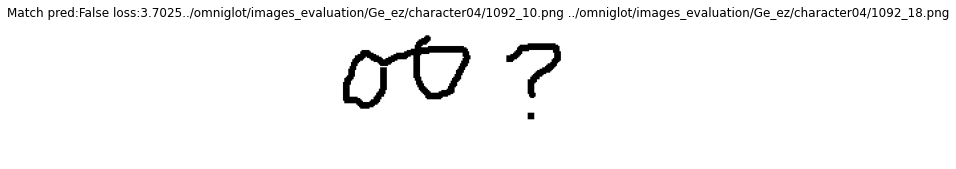

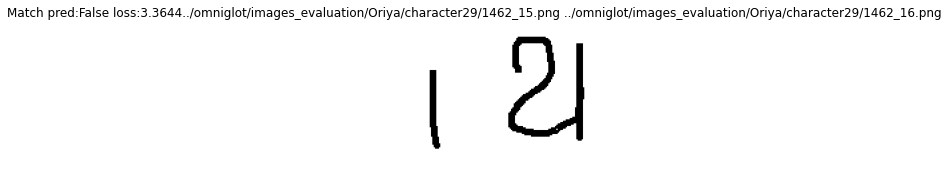

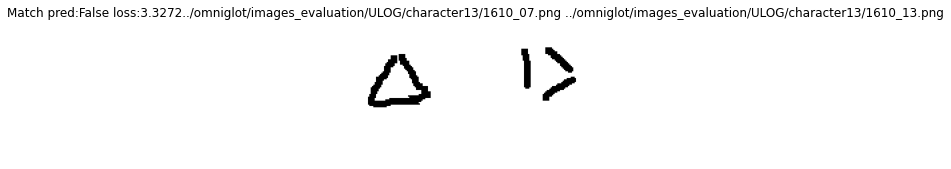

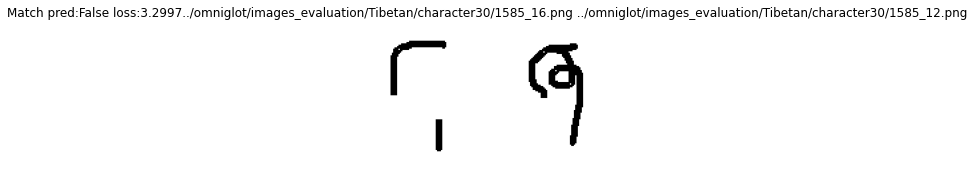

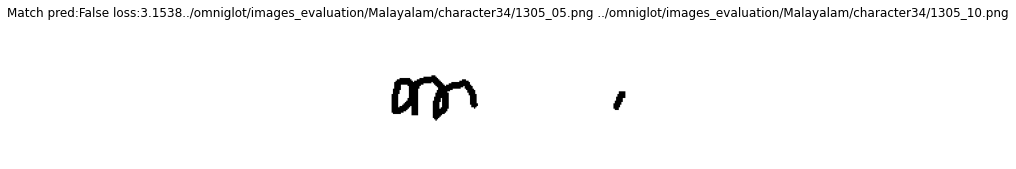

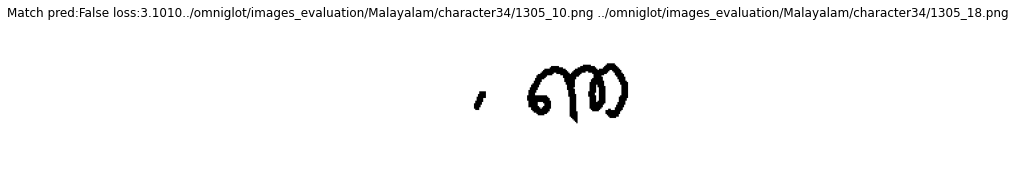

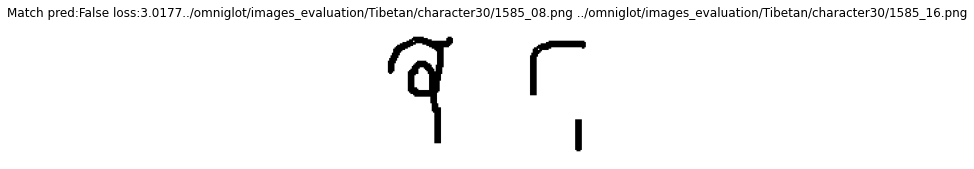

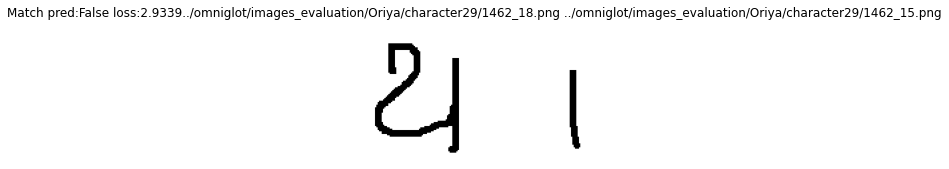

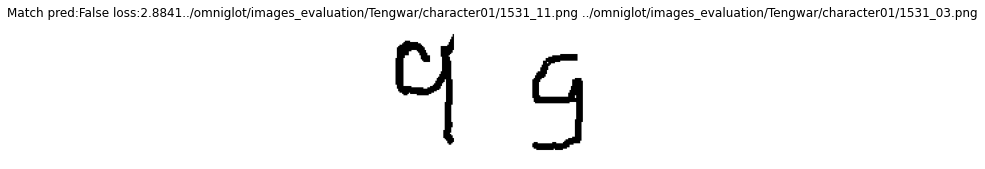

In [77]:
top_loss(interp.ids, interp.pred, interp.y, interp.loss, interp.ds, fn_info=True, kind='frr',limit=10)

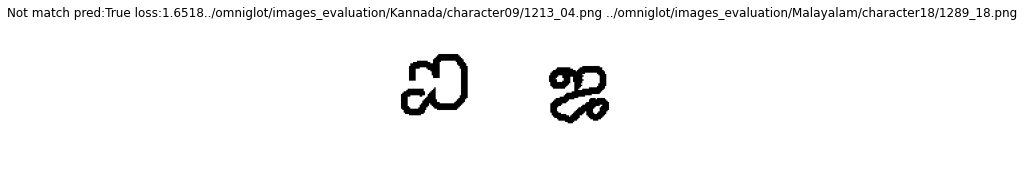

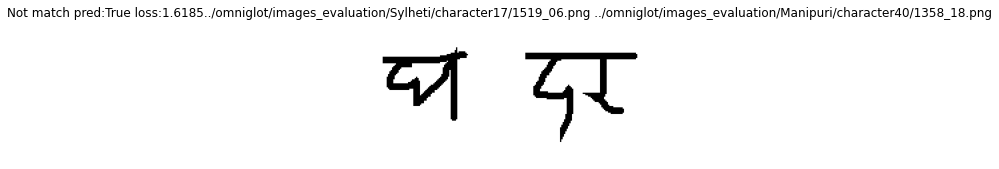

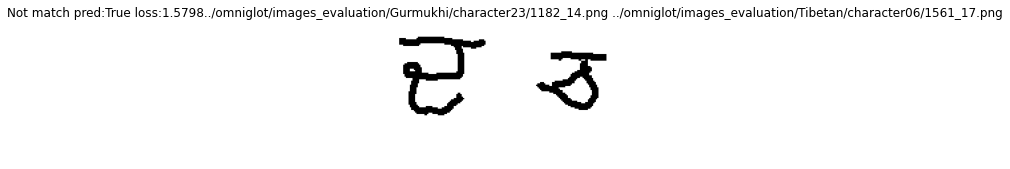

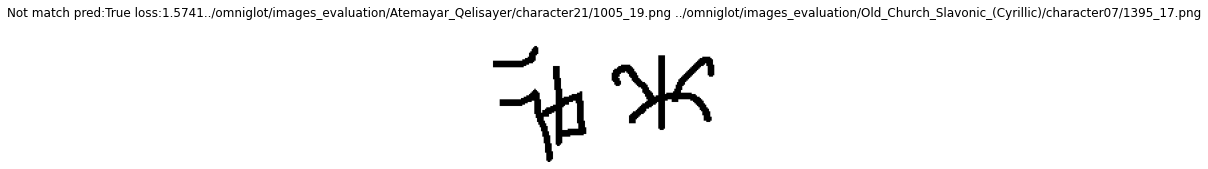

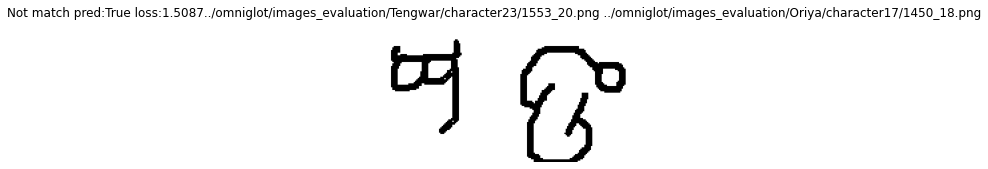

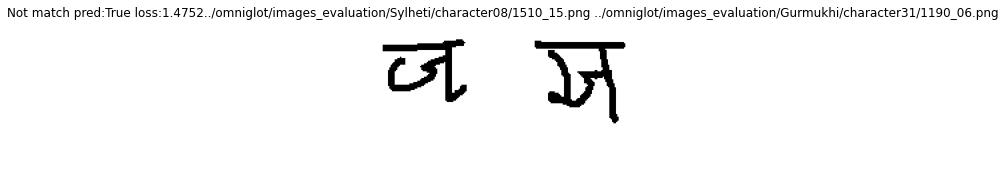

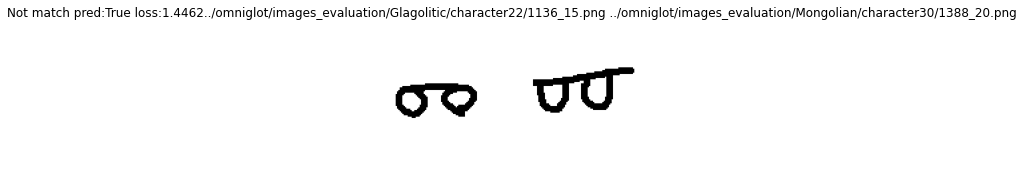

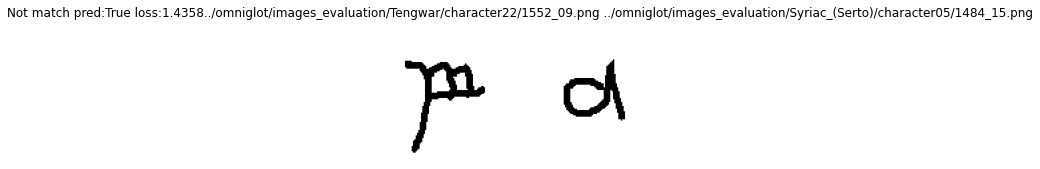

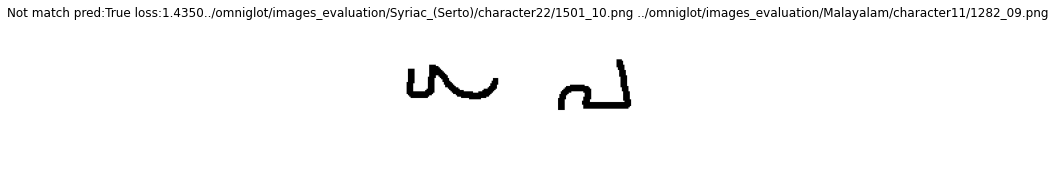

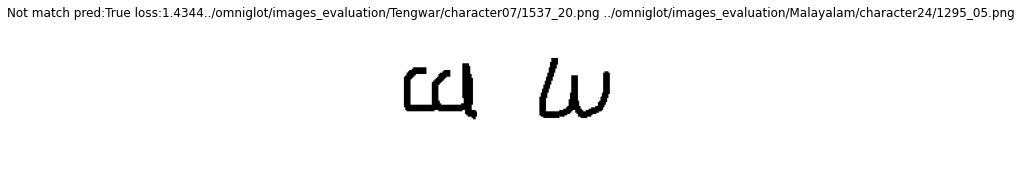

In [78]:
top_loss(interp.ids, interp.pred, interp.y, interp.loss, interp.ds, fn_info=True, kind='far',limit=10)

# Visualizing

In [80]:
fns_omniglot_train = get_image_files(path_omniglot/'images_background')
fns_omniglot_test  = get_image_files(path_omniglot/'images_evaluation')
fns_mnist          = get_image_files_truncated(10000)(path_mnist)
fns_sigcomp_train  = get_originals_train(path_sigcomp_train)

In [73]:
omniglot_stats = 0.0780, 0.2681
mnist_stats = 36.8690, 89.6788
sigcomp_train_stats = 0.0594, 0.2364

In [7]:
# Single DS omniglot train
tsfm = transforms.Normalize(*omniglot_stats)
sds_train  = SingleDS(fns_omniglot_train, get_x_omniglot, get_y_omniglot, tsfm)
e = Embeddings(sds_train, 'omniglot_train')

In [81]:
# Single DS omniglot valid
tsfm = transforms.Normalize(*omniglot_stats)
sds_valid  = SingleDS(fns_omniglot_test, get_x_omniglot, get_y_omniglot, tsfm)
e = Embeddings(sds_valid, 'omniglot_valid')

In [15]:
# Single DS MNIST
tsfm = transforms.Normalize(*mnist_stats)
sds_mnist  = SingleDS(fns_mnist, get_x_mnist, get_y_mnist, tsfm)
e = Embeddings(sds_mnist, 'mnist')

In [26]:
# Single DS Sigcomp2009 train
tsfm = transforms.Normalize(*sigcomp_train_stats)
sds_sigcomp_train  = OmniglotDS(fns_sigcomp_train, get_x_sigcomp2009, get_y_sigcomp2009_train, tsfm)
e = Embeddings(sds_sigcomp_train, 'sigcomp_train')

In [82]:
e.save()

embeddings-omniglot_valid.pt saved


In [83]:
e.xs,e.ys = get_embeddings(e.dl, learn.model)
e.save()

100%|██████████| 52/52 [00:11<00:00,  4.52it/s]


embeddings-omniglot_valid.pt saved


In [84]:
xs_pca2d = e.xs.pca(2)

/home/jupyter/siamess/tools.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.set_prop_cycle('color', [cm(1.*i/n_cls) for i in range(n_cls)])


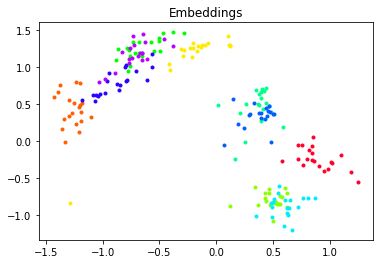

In [85]:
plotpca2d(xs_pca2d.cpu(), e.ys.cpu(),0,10)

In [86]:
xs_pca3d = e.xs.pca(3)

/home/jupyter/siamess/tools.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.set_prop_cycle('color', [cm(1.*i/n_cls) for i in range(n_cls)])


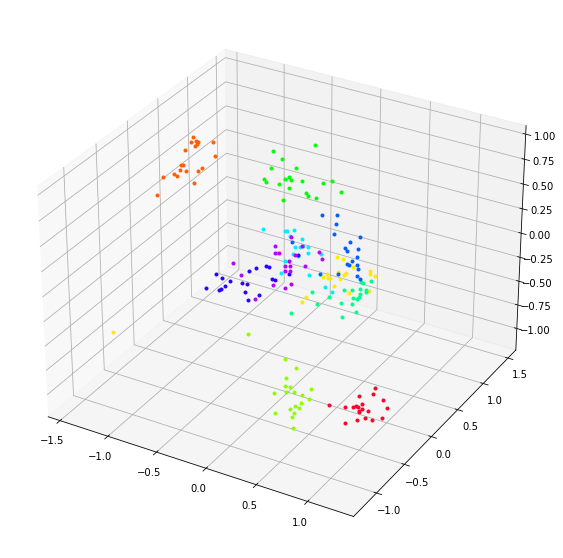

In [87]:
plotpca3d(xs_pca3d.cpu(), e.ys.cpu(),0,10)

# Fiesta!

In [3]:
e = torch.load('embeddings-omniglot_train.pt')

In [ ]:
e = torch.load('embeddings-omniglot_train_limited.pt')

In [83]:
len(set(e.ys.tolist()))

12

In [84]:
e.ys.shape

torch.Size([240])

In [88]:
msk = e.ys < 12
e.xs = e.xs[msk]
e.ys = e.ys[msk]
torch.save(e,'embeddings-omniglot_valid_limited.pt')

In [89]:
e.xs[0].tolist()

[0.0,
 0.0,
 0.0,
 0.23272711038589478,
 0.11677700281143188,
 0.0,
 0.0,
 0.7423693537712097,
 0.0,
 0.0,
 0.0,
 1.1818338632583618,
 0.0,
 0.0,
 0.060003168880939484,
 0.7849718332290649,
 1.345892310142517,
 0.8426313996315002,
 0.0,
 0.0,
 1.6863460540771484,
 1.114674687385559,
 0.7760608196258545,
 0.0,
 1.2255563735961914,
 0.09605327993631363,
 0.33299335837364197,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1840492486953735,
 1.6732556819915771,
 0.6719347834587097,
 0.0,
 2.4837613105773926,
 4.057981491088867,
 2.9566123485565186,
 0.9490383267402649,
 2.053257942199707,
 4.22567081451416,
 3.345395803451538,
 0.7846447825431824,
 0.20362161099910736,
 1.4868500232696533,
 1.7812777757644653,
 0.45970478653907776,
 1.047773003578186,
 0.749845564365387,
 1.145466923713684,
 1.068076729774475,
 1.786582112312317,
 1.6052289009094238,
 2.6727945804595947,
 1.3285210132598877,
 2.3640072345733643,
 2.1927623748779297,
 3.5060153007507324,
 2.4773950576782227,
 2.122642993927002,
 2.404019

In [3]:
def distances(x,y):
    mm = (x @ y.t())
    return (mm.diag().unsqueeze(0) - 2*mm + mm.diag().unsqueeze(1))

In [89]:
dmat=torch.cdist(e.xs,e.xs,p=2,compute_mode='use_mm_for_euclid_dist')
dmat.shape

torch.Size([240, 240])

In [90]:
n = dmat.shape[0]
n

240

In [91]:
i = 12
j = 65

In [92]:
torch.cdist(e.xs[i].unsqueeze(0),e.xs[j].unsqueeze(0)).item(), dmat[i,j], dmat[j,i]

(1.8695935010910034,
 TensorImageBW(1.8695, device='cuda:0'),
 TensorImageBW(1.8695, device='cuda:0'))

In [93]:
class SiameseDatasetAllPairsTensor(torch.utils.data.Dataset):
    """ Generic dataset for siamese image match problem (NOT USED, very slow) """
    def __init__(self, xs, ys): self.xs, self.ys, self.n = xs, ys, xs.shape[0]

    def __getitem__(self, idx):
        i     = idx // self.n
        j     = idx %  self.n
        return ( self.xs[i], self.xs[j], (self.ys[i]==self.ys[j]).float() )

    def __len__(self): return self.n*self.n

In [95]:
dsall = SiameseDatasetAllPairsTensor(nn.Unflatten(1,(512,4,4))(e.xs),e.ys)

In [95]:
dsall = SiameseDatasetAllPairsTensor(e.xs,e.ys)

In [96]:
import torch.utils.data

dlall = torch.utils.data.DataLoader(dsall, batch_size=256)

In [97]:
with torch.no_grad():
    loss_func = nn.BCEWithLogitsLoss(reduction='none')
    acts=[]
    preds=[]
    loss=[]
    for b in tqdm(dlall):
        fts = torch.cat([b[0],b[1]], dim=1)
        act = learn.model.head(fts).squeeze()
        pred = act.sigmoid()>0.5
        l = loss_func(act,b[2])
        acts.append(act)
        preds.append(pred)
        loss.append(l)

100%|██████████| 225/225 [00:03<00:00, 57.16it/s]


In [97]:
with torch.no_grad():
    acts=[]
    preds=[]
    loss=[]
    for b in tqdm(dlall):
        act = learn.model.distance_fn(b[0],b[1])
        pred = act<1
        l = learn.loss_func(act,b[2],reduction='none')
        acts.append(act)
        preds.append(pred)
        loss.append(l)

100%|██████████| 225/225 [00:04<00:00, 55.55it/s]


In [98]:
acts=torch.cat(acts)
loss=torch.cat(loss)
preds=torch.cat(preds)
acts.shape, loss.shape, preds.shape, 

(torch.Size([57600]), torch.Size([57600]), torch.Size([57600]))

In [99]:
acts=acts.view(n,n)
loss=loss.view(n,n)
preds=preds.view(n,n)

In [100]:
n*n

57600

In [101]:
acts.shape

torch.Size([240, 240])

In [102]:
ismatch = e.ys.unsqueeze(0)==e.ys.unsqueeze(1)
ismatch.shape

torch.Size([240, 240])

In [103]:
ismatch.float().sum(), n*n-ismatch.float().sum()

(tensor(4800., device='cuda:0'), tensor(52800., device='cuda:0'))

In [106]:
d=dmat[ismatch]
l=loss[ismatch]

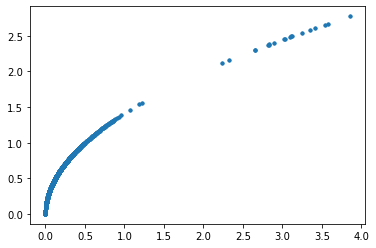

In [107]:

fig = plt.figure()
ax =  plt.axes()

plt.plot(l.cpu(),d.cpu(), '.')

In [44]:
i = 0
j = 1

In [65]:
np.correlate(l.cpu().data.numpy(), d.cpu().data.numpy())

array([706462.4], dtype=float32)

In [45]:
(e.ys[i]==e.ys[j]),  ismatch[i,j], ismatch[j,i]

(tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'))

In [55]:
def argsort2d(t, descending=False):
    m = t.shape[1]
    t = t.flatten().argsort(descending=descending)
    return t//m, t%m
t=tensor([[13,465],[15,97]])
argsort2d(t)

(tensor([0, 1, 1, 0]), tensor([0, 0, 1, 1]))

In [56]:
len(set(e.ys.tolist()))

964

In [11]:
idx=d.flatten().argsort(descending=True)[:3]

In [13]:
f_pca.shape[0]

torch.Size([13120, 2])

In [109]:
mm.diag().unsqueeze(1).t().shape

torch.Size([13120, 1])

In [74]:
math.sqrt( (f_pca[0]-f_pca[1])@(f_pca[0]-f_pca[1]).t() )

10.966543470191223

In [70]:
f_pca[0].unsqueeze(0).shape

torch.Size([1, 2])

In [78]:
F.pairwise_distance(f_pca,f_pca)

TensorImageBW([1.4142e-06, 1.4142e-06, 1.4142e-06,  ..., 1.4142e-06, 1.4142e-06, 1.4142e-06], device='cuda:0')

In [4]:
d=distances( f_pca , f_pca)
d.shape

torch.Size([13120, 13120])

In [112]:
idx=d.flatten().argsort(descending=True)[:3].cpu()
idx

TensorImageBW([16, 15,  4])

In [28]:
d.max()

TensorImageBW(3933.1084, device='cuda:0')

In [6]:
same_class = y_final.unsqueeze(0)==y_final.unsqueeze(1)
same_class

TensorCategory([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')

In [11]:
n_matches = same_class.sum()
n_unmatches = same_class.shape[0]*same_class.shape[0] - n_matches
n_matches, n_unmatches

(TensorCategory(261264, device='cuda:0'),
 TensorCategory(171873136, device='cuda:0'))

In [22]:
n_matches*n_matches-same_class.shape[0]*10

TensorCategory(68258746496, device='cuda:0')

In [23]:
d_same,_ = torch.kthvalue(d[same_class], n_matches-same_class.shape[0]*10)
d_same

TensorImageBW(195.7053, device='cuda:0')

In [24]:
d_diff,_ = torch.kthvalue(d[~same_class], same_class.shape[0]*10)
d_diff

TensorImageBW(3.3969, device='cuda:0')

In [75]:
same_and_far = torch.nonzero(same_class & (d>=d_same))
diff_and_near = torch.nonzero(~same_class & (d<=d_diff))

In [76]:
diff_and_near

TensorCategory([[    0,   909],
        [    0,  2152],
        [    0,  2441],
        ...,
        [13119,  5940],
        [13119,  6641],
        [13119,  9628]], device='cuda:0')

In [77]:
f_pca[diff_and_near[:,0]]

TensorImageBW([[19.2743, 19.8022],
        [19.2743, 19.8022],
        [19.2743, 19.8022],
        ...,
        [62.0013, 23.1626],
        [62.0013, 23.1626],
        [62.0013, 23.1626]], device='cuda:0')

In [78]:
f_pca[diff_and_near[:,1]]

TensorImageBW([[17.9010, 19.3899],
        [17.6852, 20.5818],
        [18.2052, 20.7848],
        ...,
        [61.6282, 22.7003],
        [61.6105, 24.6663],
        [61.1291, 24.5603]], device='cuda:0')

In [79]:
import itertools

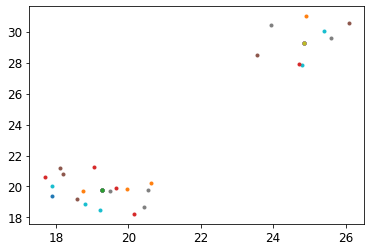

In [85]:
fig = plt.figure()  
for i, (x, y) in itertools.islice( enumerate(zip(f_pca[diff_and_near[:,0]].cpu(), f_pca[diff_and_near[:,1]].cpu())), 25):
    plt.plot(x[0], x[1], '.',label=i)
    plt.plot(y[0], y[1], '.',label=i)

ax = fig.gca()
for i, p in enumerate(ax.get_lines()):    # this is the loop to change Labels and colors
    if int(p.get_label())==(i-1):    # check for Name already exists
        idx = i-1       # find ist index
        p.set_c(ax.get_lines()[idx].get_c())   # set color
        p.set_label('_' + p.get_label())

NameError: name 'l' is not defined

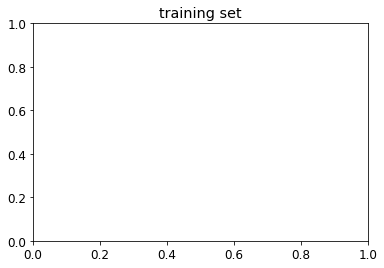

In [78]:
plt.title('training set')
for i in [15,40,20,77,88,100]:
    plt.plot(a[l==i], b[l==i], '.', label=f'class {i}')
#plt.plot(a[y_final==0][idx//20], b[y_final==0][idx//20], 'o', label=f'other')
#plt.plot(a[y_final==1][idx%20], b[y_final==1][idx%20], 'o', label=f'other')
plt.show() 

In [27]:
idx//20,idx%20

TensorImageBW([ 6, 19,  6])

In [35]:
x=f_pca[y_final==1][idx//20]
x

TensorImageBW([[-43.1183,  41.9499],
        [-43.1183,  41.9499],
        [-29.9765,  43.0367]], device='cuda:0')

In [36]:
y=f_pca[y_final==2][idx%20]
y

TensorImageBW([[ 16.4078, -36.3815],
        [ 28.9685, -16.2331],
        [ 16.4078, -36.3815]], device='cuda:0')

In [42]:
mm=x@y.t()
mm

TensorImageBW([[-2233.6760, -1930.0508, -2233.6760],
        [-2233.6760, -1930.0508, -2233.6760],
        [-2057.5845, -1566.9916, -2057.5845]], device='cuda:0')

In [118]:
idx=d[y_final==0,:][:,y_final==1].flatten().argsort()[:3]

In [110]:
maxi = 9999999999
mi = -1
mj = -1
for i,x1 in enumerate(f_pca[y_final==0]):
    for j,x2 in enumerate(f_pca[y_final==1]):
        vd=torch.cdist(x1.unsqueeze(0),x2.unsqueeze(0))
        if vd<maxi:
            maxi =vd
            mi = i
            mj=j
maxi,mi,mj
            
        

(tensor([[0.7305]], device='cuda:0'), 5, 12)

In [119]:
idx//20,idx%20

(TensorImageBW([5, 5, 7], device='cuda:0'),
 TensorImageBW([12, 15, 14], device='cuda:0'))

In [114]:
f_pca[y_final==1][idx//20]

TensorImageBW([[-20.4129,   6.8615],
        [-20.4129,   6.8615],
        [-20.4129,   6.8615]], device='cuda:0')

In [115]:
F.pairwise_distance(f_pca[y_final==0][idx//20],f_pca[y_final==1][idx%20])

TensorImageBW([82.0679, 71.5583, 78.6707], device='cuda:0')

In [65]:
learn.get_preds(dl=dls.valid, with_loss=True)

(TensorImageBW([ -3.9081,   7.4506,  -9.4083,  ...,  -1.3797, -12.3450,   4.7503]),
 tensor([0., 1., 0.,  ..., 1., 0., 1.]),
 TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03]))

In [32]:
act,y=learn.get_preds(dl=dl_minist)
act = act.cuda()
y =y.cuda()
pred = act.sigmoid()>0.5
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [33]:
(pred==y).float().mean()

TensorImageBW(0.5799, device='cuda:0')

In [279]:
toacc = []
with torch.no_glearn.frad():
    for x1,x2,y in dl_minist:
        pred = learn.model(x1.cuda(),x2.cuda()).sigmoid()>0.5
        toacc.append(pred==y)
torch.cat(toacc).float().mean()
        

TensorImageBW(0.5000, device='cuda:0')

In [278]:
(pred==y).float().mean()

TensorImageBW(0.5000, device='cuda:0')

In [54]:
act, y = learn.get_preds(dl=dls.valid)
act = act.cuda()
y = y.cuda()

In [59]:
((act.sigmoid()>0.5) == y).float().mean()

TensorImageBW(0.9380, device='cuda:0')

In [46]:
y=torch.cat([b[2] for b in dls.valid])
y

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')

In [36]:
accuracy_multi??

In [239]:
len(train_ds)/100*7

2699.2000000000003

In [185]:
tact, ty, loss = learn.get_preds(dl=dls.valid, with_loss=True)
tids = torch.argsort(loss,descending=True)

In [194]:
tact = (tact.sigmoid()>0.5)

In [195]:
tact

TensorImageBW([False,  True, False,  ..., False, False,  True])

In [186]:
loss.shape

torch.Size([26360])

In [144]:
tdl = DataLoader(train_ds,bs=256,shuffle=False, device=torch.device('cuda'))
tact, ty, loss = learn.get_preds(dl=tdl, with_loss=True)
tids = torch.argsort(loss,descending=True)


TensorImageBW([3.3373e-04, 1.4312e-02, 3.9934e-05,  ..., 6.9412e-02, 1.8516e-02, 4.2128e-02])

In [138]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [118]:
tids = torch.argsort(loss,descending=True)
tids

TensorImageBW([37547, 31867, 12085,  ..., 32662, 32672,   930])

In [188]:
loss

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03])

In [189]:
l

TensorImageBW([1.9879e-02, 5.8086e-04, 8.2013e-05,  ..., 1.6042e+00, 4.4107e-06, 8.6117e-03], device='cuda:0')

In [130]:
xx=[train_ds[0],train_ds[1]]

In [179]:
tmp_dl = DataLoader(valid_ds,bs=256,shuffle=False)
loss_no_reduction=nn.BCEWithLogitsLoss(reduction='none')
l = []
with torch.no_grad():
    for x1,x2,y in tmp_dl:
        prob = learn.model(x1.cuda(),x2.cuda())
        loss = loss_no_reduction(prob,y.cuda())
        l.append(loss)
len(l)

103

In [180]:
l=torch.cat(l)

In [135]:
l

TensorImageBW([0.0326, 0.0020], device='cuda:0')

In [148]:
ids = torch.argsort(l,descending=True)tact

TypeError: argsort() received an invalid combination of arguments - got (list, descending=bool), but expected one of:
 * (Tensor input, name dim, bool descending)
 * (Tensor input, int dim, bool descending)


In [63]:
ids

TensorImageBW([37547, 12107, 26026,  ..., 38372, 38386, 38460], device='cuda:0')

In [163]:
v,i=interp.top_losses(100)
i

TensorImageBW([ 4111,  4087,  4097, 10151, 23107, 15555, 10133, 10157, 15531,  4563, 23081,  4599,  6043, 23109, 15527, 17373, 13061,  4891, 15415,  2381, 19063, 16011,  9505,  4561,  2615, 24361, 15899,
        24381, 15377, 16211,  4423,  9489, 15485,  4195,  8547,   465, 10617, 15135,  7531, 13077, 15433, 21837,  9882,   633, 15633, 24485, 15251, 15133,  2203, 24491,  5501, 15249, 15131, 12097,
        15505, 15159,  9756, 11027,  4449,  9093, 15947,  8197, 24505, 16089, 16109, 23218, 22115,  2233, 24489, 12274,  4197, 15277,  4333,  3882,  4191, 25047, 15551, 13959,  5475, 11015, 16019,
        15411,  5281, 15915,   418, 13244, 10740, 19148,  2213, 26060, 16229, 19196, 19128,  9484,  5461,  3614, 21443,  4994,  5106, 21665])

In [92]:
w1 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
w2 = widgets.Checkbox(
        value=False,
        description="It's wrong",
        disabled=False
    )
widgets.VBox([w1,w2])

In [116]:
def img_w(fn):
    w = widgets.Image(value=open(fn,'rb').read(),
                      format='png',
                      width=100,
                      height=100)
    return w
def imgs_wg(fns): return widgets.Box([ img_w(fn) for fn in fns])
    

In [117]:
fns = [path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png',
       path/'images_evaluation/Atemayar_Qelisayer/character24/1008_18.png']
imgs_wg(fns)


Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00i\x00\x00\x00i\x01\x00\x00\x00\x00\…

In [90]:
w1.value, w2.value

(False, True)